Results for Unequal Data Distribution Scenario:
Accuracy with Simple Averaging: 64.45%
Accuracy with Weighted Averaging: 93.99%
Simple Averaging Accuracy: 64.45%
Weighted Averaging Accuracy: 93.99%
Results for Unequal Data Distribution Scenario:
Accuracy with Simple Averaging: 38.84%
Accuracy with Weighted Averaging: 60.51%


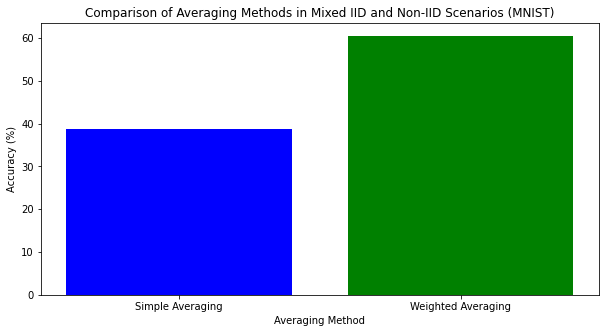

In [25]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Define the neural network architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
def prepare_data_loaders():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataset_size = len(dataset)
    indices = np.random.permutation(dataset_size)

    # Calculate splits
    split20 = int(np.floor(0.2 * dataset_size))
    split40 = int(np.floor(0.4 * dataset_size))

    # Assign 20% to three clients and 40% to one client
    loader1 = DataLoader(Subset(dataset, indices[:split20]), batch_size=64, shuffle=True)
    loader2 = DataLoader(Subset(dataset, indices[split20:2*split20]), batch_size=64, shuffle=True)
    loader3 = DataLoader(Subset(dataset, indices[2*split20:3*split20]), batch_size=64, shuffle=True)
    loader4 = DataLoader(Subset(dataset, indices[3*split20:3*split20 + split40]), batch_size=64, shuffle=True)

    return loader1, loader2, loader3, loader4





# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training function for a model
def train_model(model, data_loader, device, epochs=5):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for _ in range(epochs):
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

# Aggregation functions
def average_models(models, device):
    global_model = SimpleCNN().to(device)
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([model.state_dict()[key] for model in models], 0).mean(0)
    global_model.load_state_dict(global_state_dict)
    return global_model

def weighted_average_models(models, weights, device):
    global_model = SimpleCNN().to(device)
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([model.state_dict()[key] * weight for model, weight in zip(models, weights)], 0).sum(0)
    global_model.load_state_dict(global_state_dict)
    return global_model

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

def run_experiment():
    loader1, loader2, loader3, loader4 = prepare_data_loaders()
    test_loader = DataLoader(datasets.MNIST('./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.5,), (0.5,))
    ])), batch_size=64, shuffle=False)

    models = [SimpleCNN().to(device) for _ in range(4)]
    for i, model in enumerate(models):
        train_model(model, [loader1, loader2, loader3, loader4][i], device)

    # Weights reflecting the percentage of data each client has
    weights = [0.2, 0.2, 0.2, 0.4]  # 20% for three clients, 40% for one client

    simple_avg_model = average_models(models, device)
    weighted_avg_model = weighted_average_models(models, weights, device)

    simple_avg_accuracy = evaluate_model(simple_avg_model, test_loader, device)
    weighted_avg_accuracy = evaluate_model(weighted_avg_model, test_loader, device)

    print(f"Results for Unequal Data Distribution Scenario:")
    print(f"Accuracy with Simple Averaging: {simple_avg_accuracy:.2f}%")
    print(f"Accuracy with Weighted Averaging: {weighted_avg_accuracy:.2f}%")

    return simple_avg_accuracy, weighted_avg_accuracy

# Execute the experiment
iid_simple_acc, iid_weighted_acc = run_experiment()

# Output the results
print(f"Simple Averaging Accuracy: {iid_simple_acc:.2f}%")
print(f"Weighted Averaging Accuracy: {iid_weighted_acc:.2f}%")




# Run experiment
iid_simple_acc, iid_weighted_acc = run_experiment()

# Plotting the results
labels = ['Simple Averaging', 'Weighted Averaging']
accuracies = [iid_simple_acc, iid_weighted_acc]
plt.figure(figsize=(10, 5))
plt.bar(labels, accuracies, color=['blue', 'green'])
plt.xlabel('Averaging Method')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Averaging Methods in Mixed IID and Non-IID Scenarios (MNIST)')
plt.show()


In [26]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Define the neural network architecture for CIFAR-10
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # Adjusted for the downsampled image size
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def prepare_data_loaders():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Appropriate for RGB
    ])
    dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    dataset_size = len(dataset)
    indices = np.random.permutation(dataset_size)

    split20 = int(np.floor(0.2 * dataset_size))
    split40 = int(np.floor(0.4 * dataset_size))

    loader1 = DataLoader(Subset(dataset, indices[:split20]), batch_size=64, shuffle=True)
    loader2 = DataLoader(Subset(dataset, indices[split20:2*split20]), batch_size=64, shuffle=True)
    loader3 = DataLoader(Subset(dataset, indices[2*split20:3*split20]), batch_size=64, shuffle=True)
    loader4 = DataLoader(Subset(dataset, indices[3*split20:3*split20 + split40]), batch_size=64, shuffle=True)

    return loader1, loader2, loader3, loader4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, data_loader, device, epochs=5):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for _ in range(epochs):
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

def average_models(models, device):
    global_model = SimpleCNN().to(device)
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([model.state_dict()[key] for model in models], 0).mean(0)
    global_model.load_state_dict(global_state_dict)
    return global_model

def weighted_average_models(models, weights, device):
    global_model = SimpleCNN().to(device)
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([model.state_dict()[key] * weight for model, weight in zip(models, weights)], 0).sum(0)
    global_model.load_state_dict(global_state_dict)
    return global_model

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

def run_experiment():
    loader1, loader2, loader3, loader4 = prepare_data_loaders()
    test_loader = DataLoader(datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])), batch_size=64, shuffle=False)

    models = [SimpleCNN().to(device) for _ in range(4)]
    for i, model in enumerate(models):
        train_model(model, [loader1, loader2, loader3, loader4][i], device)

    weights = [0.2, 0.2, 0.2, 0.4]  # Reflecting the data distribution

    simple_avg_model = average_models(models, device)
    weighted_avg_model = weighted_average_models(models, weights, device)

    simple_avg_accuracy = evaluate_model(simple_avg_model, test_loader, device)
    weighted_avg_accuracy = evaluate_model(weighted_avg_model, test_loader, device)

    print(f"Results for CIFAR-10 with Unequal Data Distribution Scenario:")
    print(f"Accuracy with Simple Averaging: {simple_avg_accuracy:.2f}%")
    print(f"Accuracy with Weighted Averaging: {weighted_avg_accuracy:.2f}%")

    return simple_avg_accuracy, weighted_avg_accuracy

iid_simple_acc, iid_weighted_acc = run_experiment()


Files already downloaded and verified
Results for CIFAR-10 with Unequal Data Distribution Scenario:
Accuracy with Simple Averaging: 14.27%
Accuracy with Weighted Averaging: 22.79%


In [28]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Define the neural network architecture suitable for MNIST
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Adjusted for 1-channel grayscale images
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  # Adjusted for the downsampled image size
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def prepare_data_loaders():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Appropriate for grayscale images
    ])
    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataset_size = len(dataset)
    indices = np.random.permutation(dataset_size)

    # Evenly distribute data: 25% to each client
    split = int(dataset_size / 4)

    loader1 = DataLoader(Subset(dataset, indices[:split]), batch_size=64, shuffle=True)
    loader2 = DataLoader(Subset(dataset, indices[split:2*split]), batch_size=64, shuffle=True)
    loader3 = DataLoader(Subset(dataset, indices[2*split:3*split]), batch_size=64, shuffle=True)
    loader4 = DataLoader(Subset(dataset, indices[3*split:]), batch_size=64, shuffle=True)

    return loader1, loader2, loader3, loader4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, data_loader, device, epochs=5):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for _ in range(epochs):
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

def average_models(models, device):
    global_model = SimpleCNN().to(device)
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([model.state_dict()[key] for model in models], 0).mean(0)
    global_model.load_state_dict(global_state_dict)
    return global_model

def weighted_average_models(models, weights, device):
    global_model = SimpleCNN().to(device)
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([model.state_dict()[key] * weight for model, weight in zip(models, weights)], 0).sum(0)
    global_model.load_state_dict(global_state_dict)
    return global_model

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

def run_experiment():
    loader1, loader2, loader3, loader4 = prepare_data_loaders()
    test_loader = DataLoader(datasets.MNIST('./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.5,), (0.5,))
    ])), batch_size=64, shuffle=False)

    models = [SimpleCNN().to(device) for _ in range(4)]
    for i, model in enumerate(models):
        train_model(model, [loader1, loader2, loader3, loader4][i], device)

    weights = [0.25, 0.25, 0.25, 0.25]  # Equal weights reflecting equal data distribution

    simple_avg_model = average_models(models, device)
    weighted_avg_model = weighted_average_models(models, weights, device)

    simple_avg_accuracy = evaluate_model(simple_avg_model, test_loader, device)
    weighted_avg_accuracy = evaluate_model(weighted_avg_model, test_loader, device)

    print(f"Results for Equal Data Distribution Scenario:")
    print(f"Accuracy with Simple Averaging: {simple_avg_accuracy:.2f}%")
    print(f"Accuracy with Weighted Averaging: {weighted_avg_accuracy:.2f}%")

    return simple_avg_accuracy, weighted_avg_accuracy

iid_simple_acc, iid_weighted_acc = run_experiment()

print(f"Simple Averaging Accuracy: {iid_simple_acc:.2f}%")
print(f"Weighted Averaging Accuracy: {iid_weighted_acc:.2f}%")


Results for Equal Data Distribution Scenario:
Accuracy with Simple Averaging: 70.90%
Accuracy with Weighted Averaging: 70.90%
Simple Averaging Accuracy: 70.90%
Weighted Averaging Accuracy: 70.90%


In [30]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Define the neural network architecture for CIFAR-10
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # For 3-channel RGB images
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # Adjusted for CIFAR-10's 32x32 images after pooling
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def prepare_data_loaders():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalization for CIFAR-10
    ])
    dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    dataset_size = len(dataset)
    indices = np.random.permutation(dataset_size)

    # Evenly distribute data: 25% to each client
    split = int(dataset_size / 4)

    loader1 = DataLoader(Subset(dataset, indices[:split]), batch_size=64, shuffle=True)
    loader2 = DataLoader(Subset(dataset, indices[split:2*split]), batch_size=64, shuffle=True)
    loader3 = DataLoader(Subset(dataset, indices[2*split:3*split]), batch_size=64, shuffle=True)
    loader4 = DataLoader(Subset(dataset, indices[3*split:]), batch_size=64, shuffle=True)

    return loader1, loader2, loader3, loader4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, data_loader, device, epochs=5):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for _ in range(epochs):
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

def average_models(models, device):
    global_model = SimpleCNN().to(device)
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([model.state_dict()[key] for model in models], 0).mean(0)
    global_model.load_state_dict(global_state_dict)
    return global_model

def weighted_average_models(models, weights, device):
    global_model = SimpleCNN().to(device)
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([model.state_dict()[key] * weight for model, weight in zip(models, weights)], 0).sum(0)
    global_model.load_state_dict(global_state_dict)
    return global_model

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

def run_experiment():
    loader1, loader2, loader3, loader4 = prepare_data_loaders()
    test_loader = DataLoader(datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])), batch_size=64, shuffle=False)

    models = [SimpleCNN().to(device) for _ in range(4)]
    for i, model in enumerate(models):
        train_model(model, [loader1, loader2, loader3, loader4][i], device)

    weights = [0.25, 0.25, 0.25, 0.25]  # Equal weights reflecting equal data distribution

    simple_avg_model = average_models(models, device)
    weighted_avg_model = weighted_average_models(models, weights, device)

    simple_avg_accuracy = evaluate_model(simple_avg_model, test_loader, device)
    weighted_avg_accuracy = evaluate_model(weighted_avg_model, test_loader, device)

    print(f"Results for CIFAR-10 with Equal Data Distribution Scenario:")
    print(f"Accuracy with Simple Averaging: {simple_avg_accuracy:.2f}%")
    print(f"Accuracy with Weighted Averaging: {weighted_avg_accuracy:.2f}%")

    return simple_avg_accuracy, weighted_avg_accuracy

iid_simple_acc, iid_weighted_acc = run_experiment()

print(f"Simple Averaging Accuracy: {iid_simple_acc:.2f}%")
print(f"Weighted Averaging Accuracy: {iid_weighted_acc:.2f}%")


Files already downloaded and verified
Results for CIFAR-10 with Equal Data Distribution Scenario:
Accuracy with Simple Averaging: 17.22%
Accuracy with Weighted Averaging: 17.22%
Simple Averaging Accuracy: 17.22%
Weighted Averaging Accuracy: 17.22%
